In [2]:
import pandas as pd

# carrega os dados
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AEC_Projeto/articles.csv')

In [6]:
# parcial dos dados
df.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [7]:
# infos básicas dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167053 entries, 0 to 167052
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        167053 non-null  object
 1   text         166288 non-null  object
 2   date         167053 non-null  object
 3   category     167053 non-null  object
 4   subcategory  29635 non-null   object
 5   link         167053 non-null  object
dtypes: object(6)
memory usage: 7.6+ MB


In [8]:
# alterando os nomes das variáveis
df = df.rename(columns={
    'category': 'categoria',
    'title': 'manchete'
})


In [9]:
# quantidade de linha e colunas
df.shape

(167053, 6)

/tmp/ipython-input-10-1848030690.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='categoria', palette="Set2", order=order)


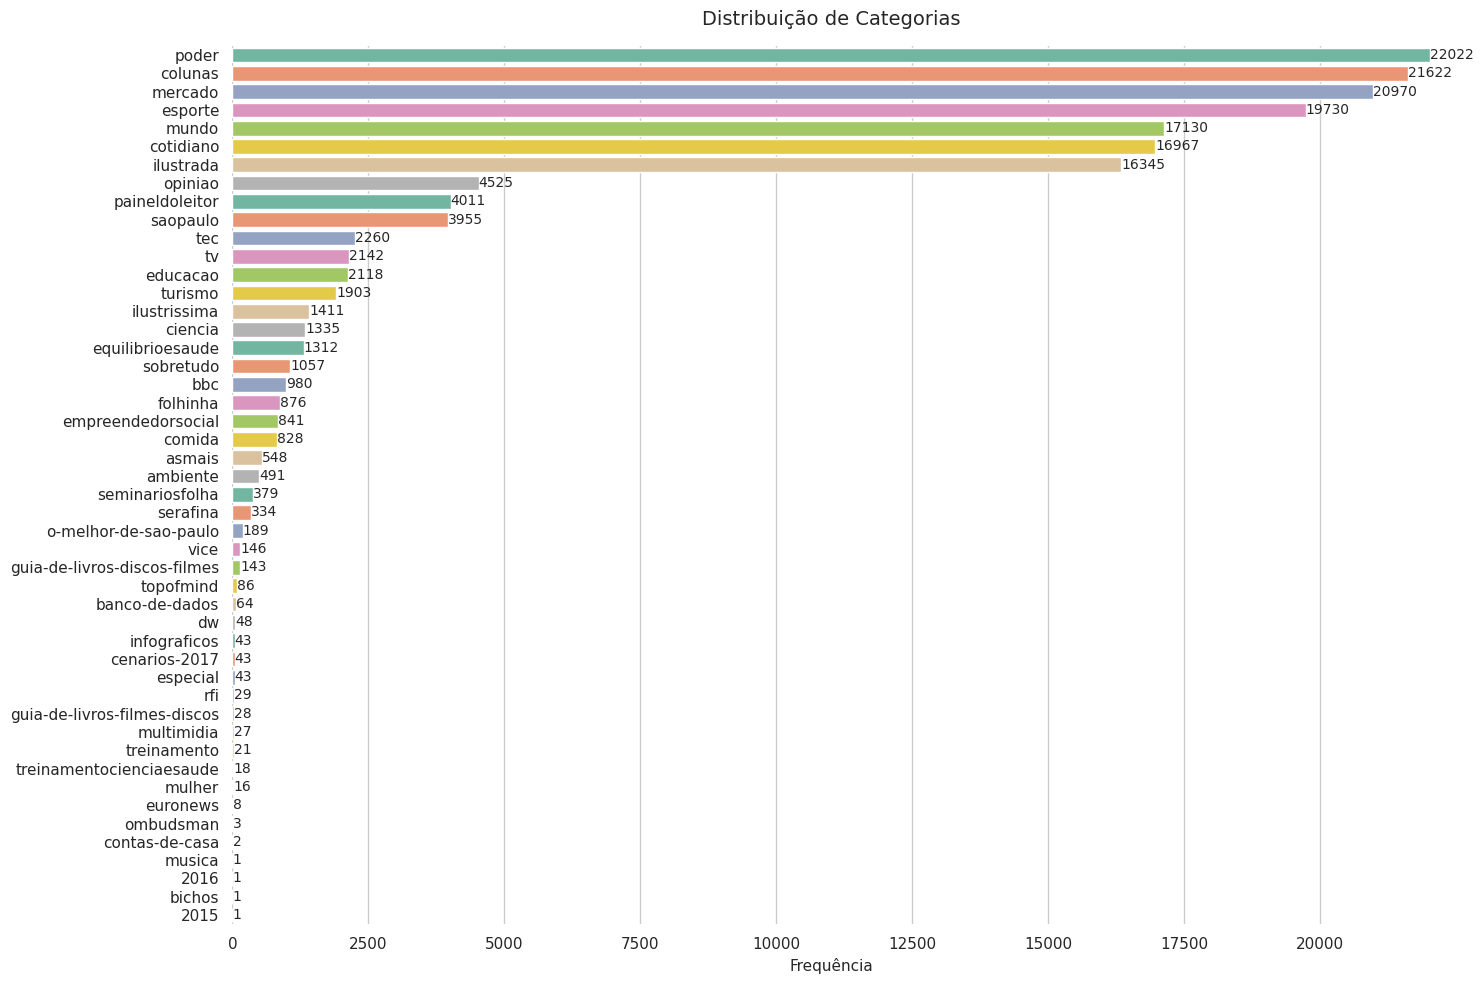

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# configura estilo do seaborn
sns.set(style="whitegrid")

# ordena as categorias por frequência (decrescente)
order = df['categoria'].value_counts().index

# cria o count plot horizontal com ordenação
plt.figure(figsize=(15, 10))
ax = sns.countplot(data=df, y='categoria', palette="Set2", order=order)

# personaliza o gráfico
plt.title("Distribuição de Categorias", fontsize=14, pad=15)
plt.xlabel("Frequência", fontsize=11)
plt.ylabel("", fontsize=11)

# adiciona contagem no final de cada barra
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.2,  # Posição x (largura da barra + pequeno offset)
            p.get_y() + p.get_height()/2,  # Posição y (centro da barra)
            f'{int(width)}',  # Texto do rótulo
            va='center', ha='left', fontsize=10)  # Alinhamento e tamanho da fonte

# ajusta os limites do eixo x para acomodar os rótulos
max_freq = df['categoria'].value_counts().max()
ax.set_xlim(0, max_freq + 1.5)

# remove as bordas
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [11]:
# filtra as categorias com pelo menos 300 ocorrências
frequencias = df['categoria'].value_counts()
categorias_validas = frequencias[frequencias >= 300].index

df_filtrado = df[df['categoria'].isin(categorias_validas)]


In [12]:
df_filtrado.shape

(166092, 6)

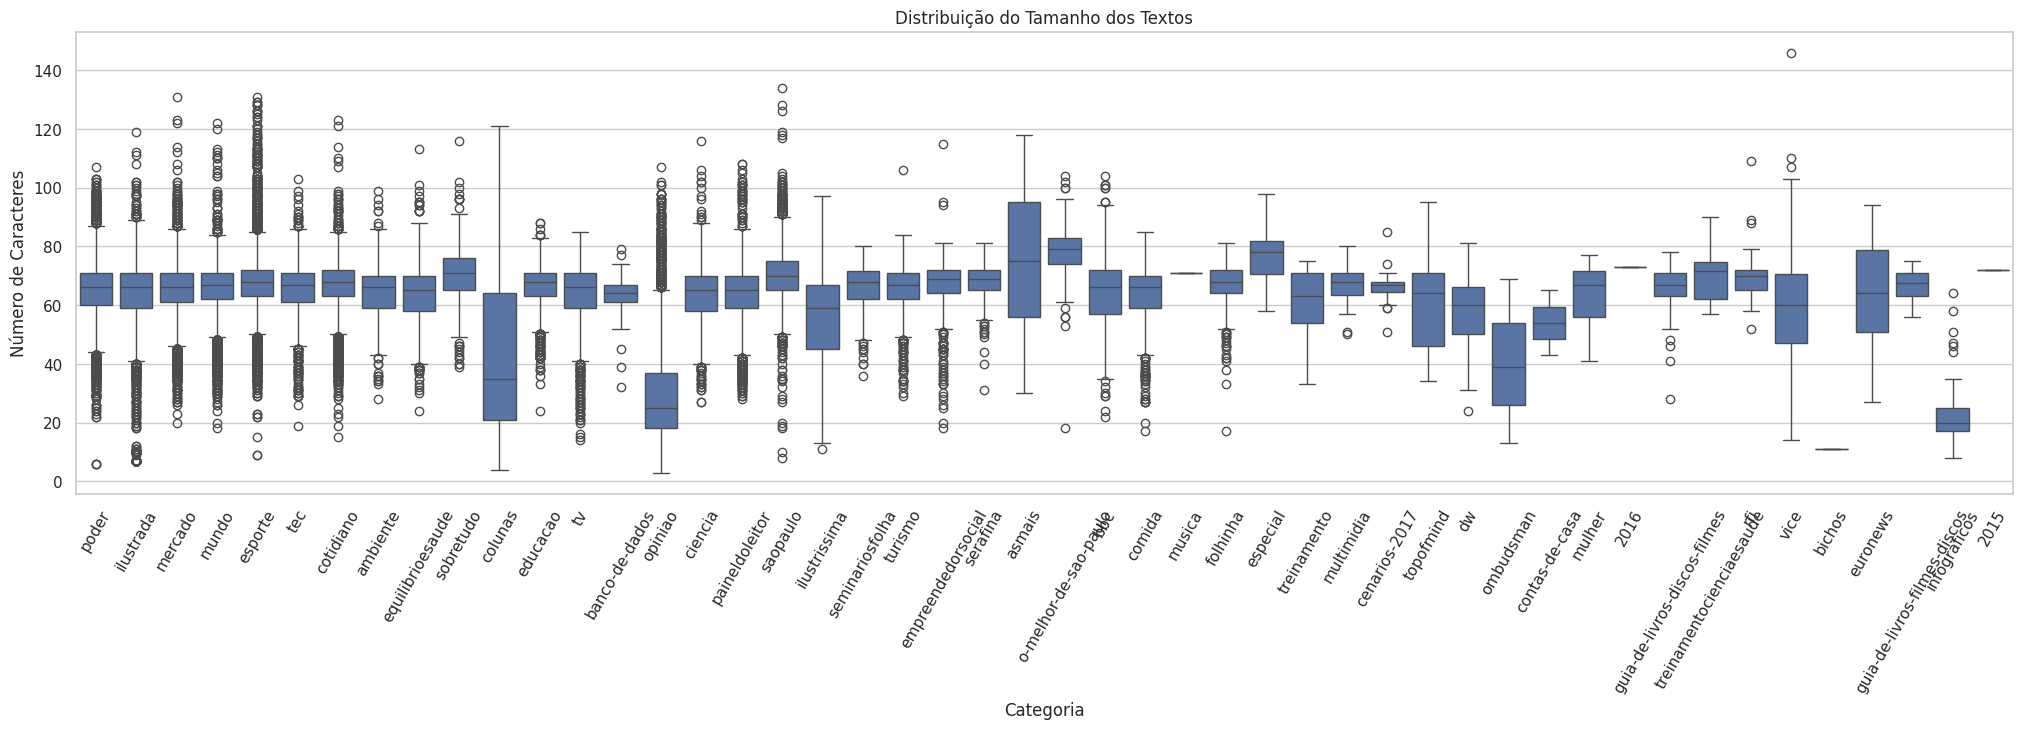

In [13]:
# gráfico boxplot com os tamanhos das categorias
df['tamanho_texto'] = df['manchete'].apply(len)

plt.figure(figsize=(25, 6))
sns.boxplot(data=df, x='categoria', y='tamanho_texto')
plt.title('Distribuição do Tamanho dos Textos')
plt.xlabel('Categoria')
plt.ylabel('Número de Caracteres')
plt.xticks(rotation=60)
plt.show()

In [14]:
# verifica a distribuição inicial dos dados para as respectivas categorias
print('Distribuição inicial das categorias:')
print(df['categoria'].value_counts())

# mostra o total de categorias e total de itens no dataset
print('\nTotal de categorias:', df['categoria'].nunique())
print('Total de itens no dataset:', df.shape[0])

Distribuição inicial das categorias:
categoria
poder                           22022
colunas                         21622
mercado                         20970
esporte                         19730
mundo                           17130
cotidiano                       16967
ilustrada                       16345
opiniao                          4525
paineldoleitor                   4011
saopaulo                         3955
tec                              2260
tv                               2142
educacao                         2118
turismo                          1903
ilustrissima                     1411
ciencia                          1335
equilibrioesaude                 1312
sobretudo                        1057
bbc                               980
folhinha                          876
empreendedorsocial                841
comida                            828
asmais                            548
ambiente                          491
seminariosfolha                   379
ser

In [16]:
# baixa os recursos NLTK para português não nativos da biblioteca
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# separa as variáveis utilizadas
texts = df['manchete']

labels = df['categoria']

# prepara as stopwords em português
stop_words = set(stopwords.words('portuguese'))

def preprocess(text):
    # tokeniza, deixa em minúsculo e filtra todas stopwords e pontuação
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens)

texts_cleaned = [preprocess(text) for text in texts]

# vetoriza com bag words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts_cleaned)

# separa em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

# treina o modelo Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [19]:
# Avalia
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.0%}")

Acurácia: 67%


In [20]:
# teste com frase nova
frase_teste = "o futebol é coletivo"
frase_teste_prep = preprocess(frase_teste)
frase_vet = vectorizer.transform([frase_teste_prep])
pred = model.predict(frase_vet)
pred

array(['esporte'], dtype='<U28')

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Visualização da simples da matriz
print("Matriz de Confusão Numérica:")
print(cm)

Matriz de Confusão Numérica:
[[ 1  0  0 ...  1  0  0]
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 85  0  0]
 [ 0  0  0 ...  2 15  0]
 [ 0  0  0 ...  0  0  0]]


In [22]:
from sklearn.metrics import classification_report

# Gera o relatório como dicionário
report = classification_report(y_test, y_pred, output_dict=True)

# Converte para DataFrame
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop(columns=['support'])

# Exibe a tabela formatada
print("\nRelatório de Classificação:")
display(df_report.style.background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score']))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Relatório de Classificação:


,precision,recall,f1-score
ambiente,1.000000,0.007407,0.014706
asmais,0.000000,0.000000,0.000000
banco-de-dados,0.000000,0.000000,0.000000
bbc,0.000000,0.000000,0.000000
cenarios-2017,0.000000,0.000000,0.000000
ciencia,0.698795,0.172107,0.276190
colunas,0.515283,0.378768,0.436603
comida,0.684211,0.060465,0.111111
contas-de-casa,0.000000,0.000000,0.000000
cotidiano,0.629139,0.820495,0.712187


In [25]:
import joblib

# Salva o modelo
joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/AEC_Projeto/model.joblib')

['/content/drive/MyDrive/Colab Notebooks/AEC_Projeto/model.joblib']